In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import deeplift 
from deeplift.conversion import kerasapi_conversion as kc

# TensorFlow and tf.keras
import tensorflow as tf
import random
from tensorflow import keras
from keras.utils import to_categorical

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# https://www.tensorflow.org/tutorials/keras/classification
print(tf.__version__)

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/Shared\ drives/CS230/datasets
import matplotlib.pyplot as plt

random.seed(42)

1.15.0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/Shared drives/CS230/datasets


In [0]:
train_seqs, dev_seqs = pd.read_csv("set1/attB2attP/train.tsv", sep='\t').attb, pd.read_csv("set1/attB2attP/dev.tsv", sep='\t').attb
train_seqs, dev_seqs = list(set(list(train_seqs))), list(set(list(dev_seqs)))
random.shuffle(train_seqs), random.shuffle(dev_seqs)
len(train_seqs), len(dev_seqs)

(17406, 2837)

In [0]:
from deeplift.dinuc_shuffle import dinuc_shuffle
def get_shuffled_controls(seqs):
  shuffled = []
  for seq in seqs:
    shufseq = list(str(seq))
    shufseq = dinuc_shuffle(shufseq)
    shufseq = ''.join(shufseq)
    shuffled.append(shufseq)
  return shuffled

In [0]:
train_seqs_cntrl, dev_seqs_cntrl = get_shuffled_controls(train_seqs), get_shuffled_controls(dev_seqs )
len(train_seqs_cntrl), len(dev_seqs_cntrl)

(17406, 2837)

In [0]:
#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    sequence = ''.join(sequence)
    to_return = np.zeros((150,4), dtype=np.int8)
    padlength = 150 - len(sequence)
    padleft = int(padlength/2)
    padright = padlength - padleft
    padded = "N"*padleft + sequence + "N"*padright
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=padded, one_hot_axis=1)
    return to_return
  
def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if char.upper()=="A":
            char_idx = 0
        elif char.upper()=="C":
            char_idx = 1
        elif char.upper()=="G":
            char_idx = 2
        elif char.upper()=="T":
            char_idx = 3
        elif char.upper()=="N":
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

In [0]:
train_seqs = np.array([one_hot_encode_along_channel_axis(seq) for seq in train_seqs])
train_seqs_cntrl = np.array([one_hot_encode_along_channel_axis(seq) for seq in train_seqs_cntrl])
dev_seqs = np.array([one_hot_encode_along_channel_axis(seq) for seq in dev_seqs])
dev_seqs_cntrl = np.array([one_hot_encode_along_channel_axis(seq) for seq in dev_seqs_cntrl])

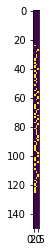

In [0]:
plt.imshow(train_seqs[0])

In [0]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
X_train = np.concatenate([train_seqs, train_seqs_cntrl])
y_train = np.reshape(np.array([1]*train_seqs.shape[0] + [0]*train_seqs_cntrl.shape[0]), (X_train.shape[0], 1))
shuffle_in_unison(X_train, y_train)

X_dev = np.concatenate([dev_seqs,dev_seqs_cntrl])
y_dev = np.reshape(np.array([1]*dev_seqs.shape[0] + [0]*dev_seqs_cntrl.shape[0]), (X_dev.shape[0], 1))
shuffle_in_unison(X_dev, y_dev)

In [0]:
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((34812, 150, 4), (34812, 1), (5674, 150, 4), (5674, 1))

In [0]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Conv1D, Flatten, MaxPooling1D, Dropout, AveragePooling1D
np.random.seed(2)
#create model
#open('model.json', 'w').write('{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Conv1D", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "conv1d_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "linear", "trainable": true, "filters": 50, "padding": "valid", "strides": [1], "dilation_rate": [1], "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "batch_input_shape": [null, 150, 4], "use_bias": true, "activity_regularizer": null, "kernel_size": [11]}}, {"class_name": "Activation", "config": {"activation": "relu", "trainable": true, "name": "activation_1"}}, {"class_name": "Conv1D", "config": {"kernel_constraint": null, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "conv1d_2", "bias_regularizer": null, "bias_constraint": null, "activation": "linear", "trainable": true, "padding": "valid", "strides": [1], "dilation_rate": [1], "kernel_regularizer": null, "filters": 50, "bias_initializer": {"class_name": "Zeros", "config": {}}, "use_bias": true, "activity_regularizer": null, "kernel_size": [11]}}, {"class_name": "Activation", "config": {"activation": "relu", "trainable": true, "name": "activation_2"}}, {"class_name": "AveragePooling1D", "config": {"padding": "valid", "strides": [80], "trainable": true, "name": "average_pooling1d_1", "pool_size": [80]}}, {"class_name": "Flatten", "config": {"trainable": true, "name": "flatten_1", "data_format": "channels_last"}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "linear", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 50, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Activation", "config": {"activation": "relu", "trainable": true, "name": "activation_3"}}, {"class_name": "Dropout", "config": {"rate": 0.5, "noise_shape": null, "trainable": true, "seed": null, "name": "dropout_1"}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_2", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "linear", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 1, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Activation", "config": {"activation": "sigmoid", "trainable": true, "name": "activation_4"}}], "backend": "tensorflow"}')
#model_json = 'model.json'
#model = model_from_json(open(model_json).read())

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=64, activation='relu', input_shape=(150, 4)))
model.add(AveragePooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=32, activation='relu'))
model.add(AveragePooling1D(pool_size=2))
#model.add(Conv1D(filters=128, kernel_size=16, activation='relu'))
#model.add(Conv1D(filters=256, kernel_size=8, activation='relu'))
#model.add(AveragePooling1D(pool_size=2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 87, 32)            8224      
_________________________________________________________________
average_pooling1d_2 (Average (None, 43, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 12, 64)            65600     
_________________________________________________________________
average_pooling1d_3 (Average (None, 6, 64)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 6, 32)             2080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 32)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 6, 16)             528       
__________

In [0]:
history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=10)

Train on 34812 samples, validate on 5674 samples
Epoch 1/10
34812/34812 [==============================] - 13s 386us/step - loss: 0.6711 - acc: 0.5609 - val_loss: 0.5837 - val_acc: 0.6918
Epoch 2/10
34812/34812 [==============================] - 11s 315us/step - loss: 0.5327 - acc: 0.7325 - val_loss: 0.4697 - val_acc: 0.7735
Epoch 3/10
34812/34812 [==============================] - 11s 311us/step - loss: 0.4569 - acc: 0.7807 - val_loss: 0.4337 - val_acc: 0.7943
Epoch 4/10
34812/34812 [==============================] - 11s 319us/step - loss: 0.4138 - acc: 0.8086 - val_loss: 0.4201 - val_acc: 0.8033
Epoch 5/10
34812/34812 [==============================] - 11s 313us/step - loss: 0.3834 - acc: 0.8266 - val_loss: 0.4079 - val_acc: 0.8134
Epoch 6/10
34812/34812 [==============================] - 11s 313us/step - loss: 0.3533 - acc: 0.8436 - val_loss: 0.4338 - val_acc: 0.8023
Epoch 7/10
34812/34812 [==============================] - 11s 317us/step - loss: 0.3304 - acc: 0.8555 - val_loss: 0.4

In [0]:
model_json = model.to_json()
with open("attb_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("attb_model.h5")

In [0]:
import deeplift
from keras.models import model_from_json

keras_model_weights = "attb_model.h5"
keras_model_json = "attb_model.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

In [0]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
reload(deeplift.layers)
reload(deeplift.conversion.kerasapi_conversion)
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 2 the preceding linear layer is preact_2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 4 the preceding linear layer is preact_4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 6 the preceding linear layer is preact_6 of type Dense;
In

ValueError: ignored

In [0]:
#make sure predictions are the same as the original model
from deeplift.util import compile_func
model_to_test = method_to_model['rescale_conv_revealcancel_fc']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(X_train, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[X_train],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 0.0


In [0]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_conv_revealcancel_fc


W1024 20:06:22.584779 139735858755456 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deeplift/layers/core.py:467: The name tf.scatter_update is deprecated. Please use tf.compat.v1.scatter_update instead.



Compiling scoring function for: rescale_all_layers
Compiling scoring function for: revealcancel_all_layers
Compiling scoring function for: grad_times_inp
Compiling scoring function for: guided_backprop
Compiling integrated gradients scoring functions


In [0]:
background = OrderedDict([('A', 0.3), ('C', 0.2), ('G', 0.2), ('T', 0.3)])

bxb1_attb = np.array([one_hot_encode_along_channel_axis('GGTGGCCGTGGCCGTGCTCGTCCTCGTCGGCCGGCTTGTCGACGACGGCGGTCTCCGTCGTCAGGATCATCCGGGCCACCGAGGCGGCGTTGAGAACAGCCG')])

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[bxb1_attb],
                    input_references_list=[
                     np.array([background['A'],
                               background['C'],
                               background['G'],
                               background['T']])[None,None,:]],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_name][task_idx] = scores
print("Prediction:", keras_model.predict(bxb1_attb))

on method rescale_conv_revealcancel_fc
on method rescale_all_layers
on method revealcancel_all_layers
on method grad_times_inp
on method guided_backprop
on method integrated_gradients10
Prediction: [[1.]]


In [0]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_conv_revealcancel_fc_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_conv_revealcancel_fc'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=100 #number of references to generate per sequence
method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(rescale_conv_revealcancel_fc_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=['GGTGGCCGTGGCCGTGCTCGTCCTCGTCGGCCGGCTTGTCGACGACGGCGGTCTCCGTCGTCAGGATCATCCGGGCCACCGAGGCGGCGTTGAGAACAGCCG'],
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2)

One hot encoding sequences...
One hot encoding done...
Done 0


Scores for task 0 for example 0
grad_times_inp


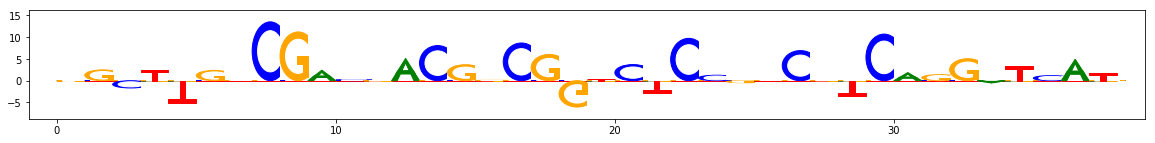

guided_backprop


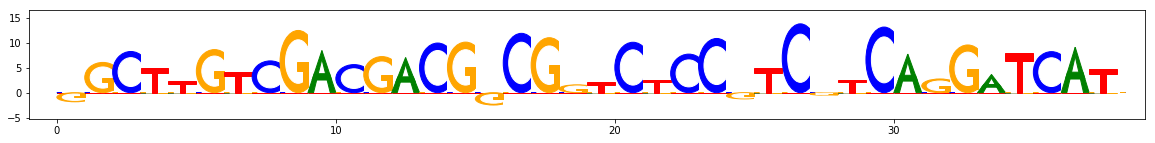

integrated_gradients10


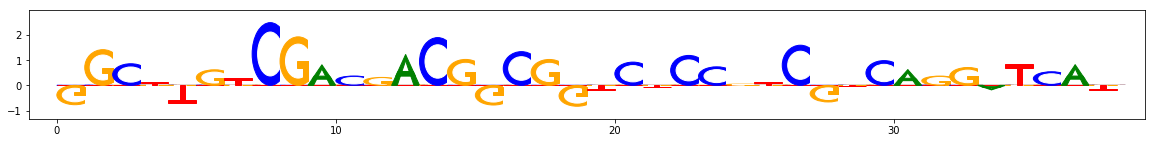

rescale_all_layers


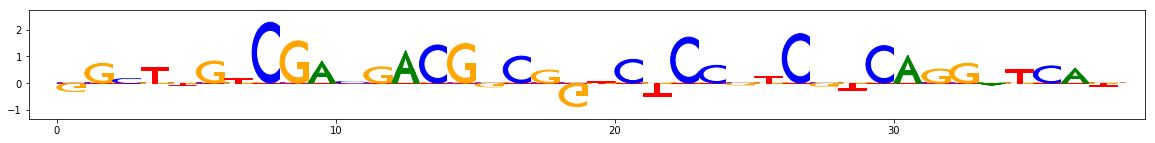

revealcancel_all_layers


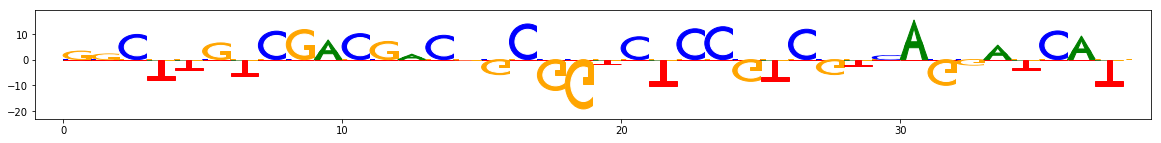

rescale_conv_revealcancel_fc


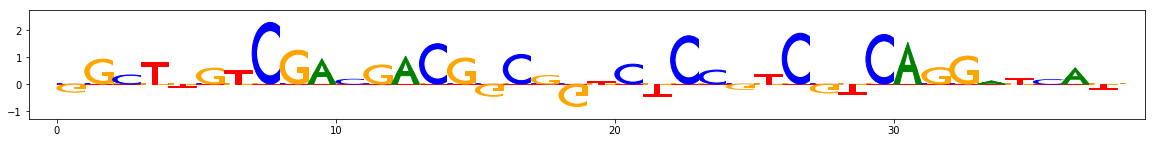

rescale_conv_revealcancel_fc_multiref_100


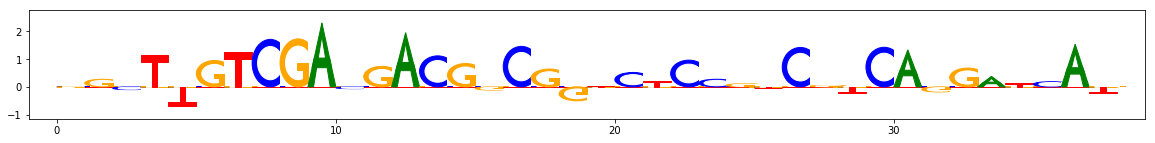

In [0]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

task, idx = 0, 0
print("Scores for task",task,"for example",idx)
for method_name in [
                    'grad_times_inp',
                    'guided_backprop',
                    'integrated_gradients10',
                    'rescale_all_layers', 'revealcancel_all_layers',
                    'rescale_conv_revealcancel_fc',
                    'rescale_conv_revealcancel_fc_multiref_100'
                    ]:
    scores = method_to_task_to_scores[method_name][task]
    scores_for_idx = scores[idx]
    original_onehot = bxb1_attb[idx]
    scores_for_idx = original_onehot*scores_for_idx[:,None]
    scores_for_idx = scores_for_idx[56:94, :]
    print(method_name)
    viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10)